# Mill tree loss and forest area calculations using Google Earth Engine
### All tree loss and area calculations are replicated in the batch layer which produces the data that serves the Tracker application.

To run this notebook, you need the following file:
1. boundaries file in geojson format - needs to contain properties 'umlid' and 'geometry' - we use a file called 'uml_boundaries.geojson' which is in a directory called 'data/' at the same level as this notebook.

In [95]:
# Imports
import ee
import json
import folium
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [96]:
# Parameters
GFC_DATASET = "UMD/hansen/global_forest_change_2019_v1_7"
DATA_DIR = "./data"
MILL_BOUNDARIES_FNAME = 'uml_boundaries.geojson'
AREA_FACTOR = 0.09      # 1 pixel is 0.09 hectares

### We will now use the Google Earth Engine API to access the Hansen data set
#### You can read more about the Hansen data set [here](https://data.globalforestwatch.org/datasets/14228e6347c44f5691572169e9e107ad).

In [97]:
# Authenticate to Google Earth Engine (GEE) by generating an access token that is copied and then pasted into this cell. You must be signed up for GEE access beforehand.
ee.Authenticate()

Enter verification code: 4/1AY0e-g7c2vJSSZk-6b6cX7QAu5s20QPSSWFY9rvyCRWH9j3G24sjrRGVLsE

Successfully saved authorization token.


In [98]:
# Initialize the Earth Engine API
ee.Initialize()

In [99]:
# Load the Global Forest Change dataset as a GEE image
gfc_img = ee.Image(GFC_DATASET)

# View available bands within the image
bandNames = gfc_img.bandNames()
print('Band names: ', bandNames.getInfo())

Band names:  ['treecover2000', 'loss', 'gain', 'lossyear', 'first_b30', 'first_b40', 'first_b50', 'first_b70', 'last_b30', 'last_b40', 'last_b50', 'last_b70', 'datamask']


In [100]:
# Bring in the mill boundaries data.
boundaries_file_path = os.path.join(DATA_DIR, MILL_BOUNDARIES_FNAME)

cwd = os.getcwd()

with open(boundaries_file_path) as f:
    data = json.load(f)

mills = data['features']

# Look at the data for the first mill.
mills[0]

FileNotFoundError: [Errno 2] No such file or directory: './data\\uml_boundaries.geojson'

In [30]:
# Create a feature collection that consists of mill boundaries so we can use the mill 
# boundaries with Earth Engine.
mill_geoms = ee.FeatureCollection(mills)

In [31]:
# Visualize mill areas using Folium
# Initialize map
INDONESIA_COORDS = [-0.7893, 113.9213]
EE_TILES = 'https://earthengine.googleapis.com/map/UMD/hansen/global_forest_change_2019_v1_7/{{z}}/{{x}}/{{y}}?token={token}'
ZOOM_START = 5
mapViz = folium.Map(location=INDONESIA_COORDS, zoom_start=ZOOM_START)

# Add polygons
folium.GeoJson(data=mill_geoms.getInfo(), name="geojson").add_to(mapViz)

# Display
mapViz

### Use Earth Engine to compute cumulative tree loss, forest area, and tree loss per year.  

#### Cumulative Tree Loss from 2001 - 2019 using 'loss' band

In [32]:
# Compute cumulative tree cover loss per mill area across **all** lossyears
# NOTE: The resulting sum is a decimal number because a weighted reduction is performed:
# https://developers.google.com/earth-engine/guides/reducers_weighting.  The sum
# is a weighted aggregation of the bitmap property "loss," which is either 0 or 1.  So 
# the area is in units of pixels (30m X 30m).

_lossdict = gfc_img.select('loss').reduceRegions(
  collection=mill_geoms,
  reducer=ee.Reducer.sum(),
  scale=30
)

# Extract sums from Earth Engine using the getInfo method
lossdict = _lossdict.getInfo()["features"]

#### Land Area using 'datamask' band

In [33]:
# Compute land area for each mill.  
# The datamask band takes one of 3 values for each pixel representing 
# areas of no data (0), 
# mapped land surface (1), 
# and permanent water bodies (2).
# Area is in units of pixels.

# For this we will use the fixedHistogram reducer instead of the sum reducer.
_landdict = gfc_img.select('datamask').reduceRegions(
                    collection=mill_geoms,
                    reducer=ee.Reducer.fixedHistogram(1, 2, 1),  # 1 bin of [1,2)
                    scale=30
                    )
landdict = _landdict.getInfo()["features"]

#### Forest area in the year 2000 using the 'treecover2000' band

In [34]:
# Compute the forest area for each mill.
# The treecover2000 band takes a value between 0 and 100 which represents the percent
# tree cover in each pixel in the year 2000.  We define forest as a pixel with > 30% 
# tree cover.
# Area is in units of pixels.

_forestdict = gfc_img.select('treecover2000').reduceRegions(
                    collection=mill_geoms,
                    reducer=ee.Reducer.fixedHistogram(30, 101, 1),   # 1 bin of [30,101)
                    scale=30
                    )
forestdict = _forestdict.getInfo()["features"]

#### Tree loss in each year from 2001 - 2019 using the 'lossyear' band

In [35]:
# Compute the tree loss area for each year from 2001 - 2019 for each mill.
# The lossyear band takes an integer value between 1 and 19 inclusive.  
# This number indicates the year in which forest loss occured in that pixel.  

_lossyeardict = gfc_img.select('lossyear').reduceRegions(
                    collection=mill_geoms,
                    reducer=ee.Reducer.fixedHistogram(1, 20, 19),   # 19 bins of 1 each from 1-19
                    scale=30
                    )
lossyeardict = _lossyeardict.getInfo()["features"]

### Data Exploration

In [36]:
# Store area and cumulative tree loss info in a dataframe.
column_names = ['umlid', "treeloss_sum"]
rows = []

for area in lossdict:
    rows.append([area['properties']['umlid'],
                    AREA_FACTOR*area['properties']['sum']])

data = pd.DataFrame(columns = column_names, data = rows)

In [37]:
len(data)

1084

In [38]:
# Add columns for land area, forest area, and tree loss in each year 2001-2019.
land_areas = []
for area in landdict:
    land_areas.append(AREA_FACTOR*area["properties"]['histogram'][0][1])
data['land_area'] = land_areas

forest_area = []
for area in forestdict:
    forest_area.append(AREA_FACTOR*area["properties"]['histogram'][0][1])
data['forest_area'] = forest_area

lossyears = list(range(1, 20))
for i, year in enumerate(lossyears):
    col_name = "treeloss_20" + str(year).zfill(2)
    loss = []
    for area in lossyeardict:
        loss.append(AREA_FACTOR*area['properties']['histogram'][i][1])

    data[col_name] = loss

In [39]:
# Add a column for tree loss as a proportion of forest.
data['treeloss_sum_proportion_forest'] = data['treeloss_sum']/data['forest_area']

In [40]:
# Add a column for the remaining proportion of forest.
data['remaining_proportion_forest'] = 1 - data['treeloss_sum_proportion_forest']

#### Summary statistics and plots.

In [41]:
data.describe()

,treeloss_sum,land_area,forest_area,treeloss_2001,treeloss_2002,treeloss_2003,treeloss_2004,treeloss_2005,treeloss_2006,treeloss_2007,...,treeloss_2012,treeloss_2013,treeloss_2014,treeloss_2015,treeloss_2016,treeloss_2017,treeloss_2018,treeloss_2019,treeloss_sum_proportion_forest,remaining_proportion_forest
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,...,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000
mean,21554.059865,78299.038151,67997.119901,573.464703,616.749211,404.123684,1011.954000,965.379771,1145.217604,1176.166878,...,1894.571813,974.961112,1528.718559,1272.025023,1920.379398,1036.187576,985.553272,925.959278,0.427143,0.572857
std,23883.452029,98525.068121,90786.931812,824.687528,880.242034,1182.640007,1480.458670,1395.905397,1579.387402,2023.995205,...,2541.789795,1395.009867,2354.094146,1996.406099,3867.166305,1272.479261,1319.000317,1240.436064,0.198852,0.198852
min,175.653176,1593.535765,1322.855647,0.000000,0.000000,0.090000,1.890000,0.360000,0.000000,0.540000,...,1.530000,0.303529,1.800000,0.180000,0.000000,1.800000,0.661765,0.000000,0.010718,-0.041372
25%,6256.001735,17431.736647,13146.047647,110.162824,116.800324,53.886441,243.679147,195.108882,224.049706,185.001706,...,258.829676,145.480676,232.079559,150.097412,244.903412,179.108206,196.321941,160.058912,0.277421,0.438438
50%,13459.040294,37656.023118,31143.517765,293.025706,351.809647,150.477529,581.370882,509.572765,664.767529,566.413765,...,880.875353,455.657118,741.991588,547.498412,825.904059,619.513588,541.632000,495.312353,0.404605,0.595395
75%,28458.957706,100805.490882,85952.972824,662.277176,768.838765,411.793059,1209.817676,1127.499088,1463.431059,1546.125706,...,2627.465029,1309.576147,1912.262824,1473.161294,1996.657324,1344.830824,1243.446088,1147.084235,0.561562,0.722579
max,209518.902706,755798.611059,748408.921059,8860.158353,9073.561765,29285.011059,21278.987647,14874.696706,27200.000118,30841.932000,...,21647.730000,13535.536588,35171.874706,22588.106824,47503.198235,9379.116353,14842.328471,10066.599176,1.041372,0.989282


Text(0, 0.5, 'mill count')

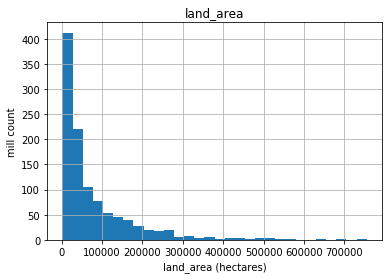

In [42]:
# Plot a histogram of land area.
data.hist('land_area', bins = 30)
plt.xlabel('land_area (hectares)')
plt.ylabel('mill count')

Text(0, 0.5, 'mill count')

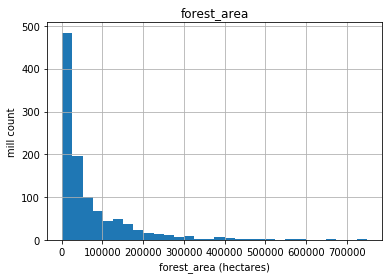

In [43]:
# Plot a histogram of forest area.
data.hist('forest_area', bins = 30)
plt.xlabel('forest_area (hectares)')
plt.ylabel('mill count')

In [44]:
# Look at the fraction of land within a mill area that is forest.
data['forest_proportion'] = data['forest_area']/data['land_area']

Text(0, 0.5, 'mill count')

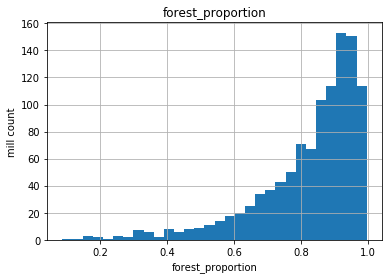

In [45]:
# Plot a histogram of forest proportion.
data.hist('forest_proportion', bins = 30)
plt.xlabel('forest_proportion')
plt.ylabel('mill count')

Makes sense - you wouldn't put a mill in a low forest density area.

Mean treeloss_sum_proportion_forest: 0.4271432633632228


Text(0, 0.5, 'mill count')

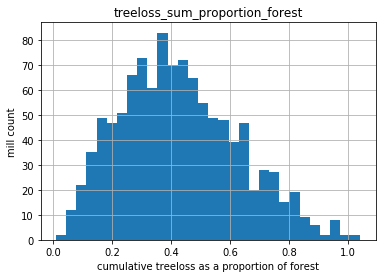

In [46]:
# Look at cumulative treeloss as a proportion of forest
# Plot a histogram.
print('Mean treeloss_sum_proportion_forest: {}'.format(np.mean(data['treeloss_sum_proportion_forest'])))
data.hist('treeloss_sum_proportion_forest', bins = 30)
plt.xlabel('cumulative treeloss as a proportion of forest')
plt.ylabel('mill count')

Text(0, 0.5, 'mill count')

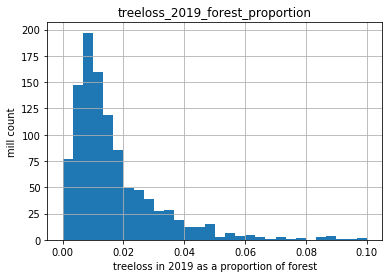

In [47]:
# Look at treeloss in the most recent year.
# Make a column for treeloss_2019 as a proportion of forest.
data['treeloss_2019_forest_proportion'] = data['treeloss_2019']/data['forest_area']

# Plot a histogram.
data.hist('treeloss_2019_forest_proportion', bins = 30, range=[0, 0.1])
plt.xlabel('treeloss in 2019 as a proportion of forest')
plt.ylabel('mill count')

### Look at total treeloss (sum for all mills) over time from 2001-2019

Text(0, 0.5, 'Total Treeloss (hectares)')

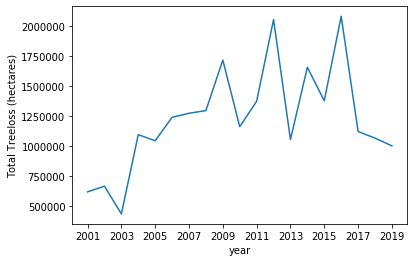

In [48]:
years = list(range(2001, 2020))
total_treeloss = [sum(data['treeloss_' + str(year)]) for year in years]
plt.plot(years, total_treeloss)
plt.xlabel('year')
plt.xticks([year for year in years if year%2 == 1])
plt.ylabel('Total Treeloss (hectares)')

### Look at correlations in treeloss from one year to the next 

In [49]:
def get_cor(year, num_prev, df):
    '''
    This function computes the correlation between the treeloss in a specified year and the
    mean treeloss over a specified number of previous years.
    
    inputs:
        year - a year between 2002 and 2019 inclusive
        num_prev - an integer for the number of years prior you want to average for the
                    comparison
        df - a dataframe with columns named 'treeloss_{year}' for 2001-2019
   
    output:
        Pearson correlation coefficient
    '''
    # get the list of columns from which to take the mean
    years = list(range(year - num_prev, year))
    prev_cols = ['treeloss_' + str(y) for y in years]
    
    # calculate the mean of previous columns for each mill.
    mean_prev = df.loc[:, prev_cols].mean(axis=1)
    
    # Get correlation.
    return np.corrcoef(mean_prev, df['treeloss_' + str(year)])[0,1]

In [50]:
# For every year from 2010 to 2019, compute the correlation for the previous 2 years.
cors = []
years = []
for year in range(2010, 2020):
    cor = get_cor(year, 2, data)
    cors.append(cor)
    years.append(year)

correlations = pd.DataFrame(data = {'year':years, 'correlation':cors})
correlations

,year,correlation
0,2010,0.604628
1,2011,0.725517
2,2012,0.740948
3,2013,0.801388
4,2014,0.779247
5,2015,0.725945
6,2016,0.649829
7,2017,0.613260
8,2018,0.705896
9,2019,0.843761


Text(0, 0.5, 'Pearson coefficient')

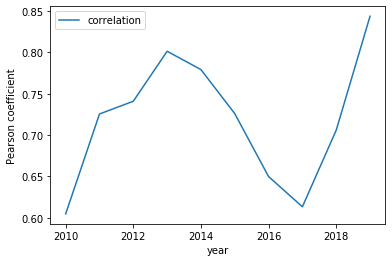

In [51]:
correlations.plot('year', 'correlation')
plt.ylabel('Pearson coefficient')

### Comparison of tree loss by RSPO-Certification

In [66]:
# Get data from csv file which includes columns of tree loss and RSPO-certification.

cwd = os.getcwd()
up_level = os.path.dirname(cwd)
data_dir = up_level + '/data'

uniquemills_df = pd.read_csv(data_dir + '/uniquemills.csv')

In [70]:
# Create a column for treeloss_2019 as a proportion of forest as done before.

uniquemills_df['treeloss_2019_forest_proportion'] = uniquemills_df['treeloss_2019']/uniquemills_df['forest_area']

#### Create Boxplot

Text(0.5, 0, 'RSPO-Certification Status')

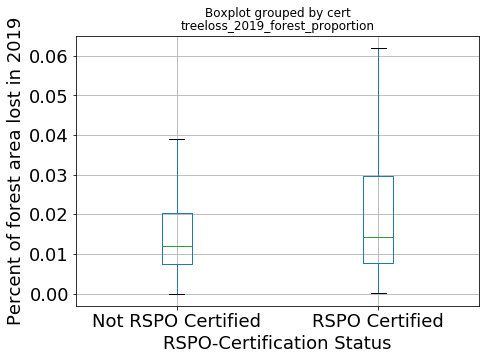

In [69]:
# Create a boxplot of forest area lost in 2019 by RSPO-certification.

ax = uniquemills_df.boxplot(column='treeloss_2019_forest_proportion', by='cert', showfliers=False, fontsize=18, figsize=(7,5))
ax.set_ylabel('Percent of forest area lost in 2019', fontsize=18)
ax.set_xlabel('RSPO-Certification Status', fontsize=18)


#### T-Test to Detect Statistically Significant Difference in Means

In [94]:
from scipy.stats import ttest_ind

# Create Pandas Series of Certified/Non-certified mills
certified_mills = uniquemills_df['treeloss_2019_forest_proportion'][uniquemills_df['cert']=='RSPO Certified']
not_certified_mills = uniquemills_df['treeloss_2019_forest_proportion'][uniquemills_df['cert']=='Not RSPO Certified']

# Drop NAs to run t-test
certified_mills = certified_mills.dropna()
not_certified_mills = not_certified_mills.dropna()

# Run t-test
stat, p = ttest_ind(certified_mills, not_certified_mills)
print('2019 treeloss in proportion to forest area:')
print('T-Stat=%.3f, p=%.3f \n' % (stat, p))


2019 treeloss in proportion to forest area:
T-Stat=2.413, p=0.016 



From the p-value returned, we can conclude that the 2019 tree loss of certified mills is statistically significantly greater than that of not certified mills.